In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


/Users/shaoliang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/shaoliang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


38951745

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [2]:
PATH = "./" #CHANGE THIS - path where the pickled data is stored


with open(os.path.join(PATH, "sig_data_train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)

print("X's length {}".format(len(X)))

# print("training alphabets")  
# print("X's shape {}".format(X.shape))
# print("training alphabets")
# print(c.keys())
print("validation alphabets:")
print(cval.keys())

X's length 806
validation alphabets:
dict_keys(['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic'])


In [30]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["sig_data_train", "val"]):
        self.data = {}
        self.author_dict = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,a) = pickle.load(f)
                self.data[name] = X
                self.author_dict[name] = a

    def get_batch(self,batch_size,s="sig_data_train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        author_dict = self.author_dict[s]
        sig_examples = len(X)
        author_examples = len(author_dict)
        w,h = X[0].shape

        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.ones((batch_size,))
        targets[batch_size//2:] = 0
        
        i = 0
        #pick images from same author for the first half input
        while i < batch_size // 2:
            author_id = rng.choice(list(author_dict))
            num_of_index = len(author_dict[author_id])
            if num_of_index <= 1:
                continue
            else:                
                idx_1 = rng.randint(0, num_of_index)
                idx_2 = rng.randint(0, num_of_index)
                pairs[0][i,:,:,:] = X[author_dict[author_id][idx_1]].reshape(w, h, 1)
                pairs[1][i,:,:,:] = X[author_dict[author_id][idx_2]].reshape(w, h, 1)
                i += 1

        #pick images from differnt author for the second half input
        while i < batch_size:
            author_id_1 = rng.choice(list(author_dict))
            author_id_2 = rng.choice(list(author_dict))
            if author_id_1 == author_id_2:
                continue
            else:
                num_of_index_1 = len(author_dict[author_id_1])
                num_of_index_2 = len(author_dict[author_id_2])
                idx_1 = rng.randint(0, num_of_index_1)
                idx_2 = rng.randint(0, num_of_index_2)
                pairs[0][i,:,:,:] = X[author_dict[author_id_1][idx_1]].reshape(w, h, 1)
                pairs[1][i,:,:,:] = X[author_dict[author_id_2][idx_2]].reshape(w, h, 1)
                i += 1
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot_ori(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def test_oneshot(self,model,size,s="sig_data_train"):
        print("Evaluating accuracy......")
        inputs, targets = self.get_batch(size,s)
        #inputs, targets = shuffle(inputs, targets)
        probs = model.predict(inputs)
        probs = probs > 0.5
        probs = probs.reshape(1,size)
        print("probs in test_oneshot {}".format(probs))
        print("targets in test_oneshot {}".format(targets))
        print("probs == targets in test_oneshot {}".format(probs == targets))
        corrects = np.sum(probs == targets)
        print("corrects in test_oneshot {}".format(corrects))
        
        percent_correct = (100.0 * corrects / size)
        print("Got an average of {}%  one-shot learning accuracy".format(percent_correct))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)
pairs,target = loader.get_batch(10)
print("No of pairs0 {}".format(len(pairs[0])))
print("No of pairs1 {}".format(len(pairs[1])))
print("target {}".format(target))

loading data from ./sig_data_train.pickle
loading data from ./val.pickle
No of pairs0 10
No of pairs1 10
target [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


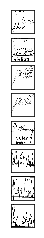

In [17]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task_original(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_batch_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8)
    
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)

    ax2.matshow(pairs[1][0].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    
    ax3.matshow(pairs[0][4].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax3.get_yaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)

    ax4.matshow(pairs[1][4].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax4.get_yaxis().set_visible(False)
    ax4.get_xaxis().set_visible(False)

    ax5.matshow(pairs[0][5].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax5.get_yaxis().set_visible(False)
    ax5.get_xaxis().set_visible(False)

    ax6.matshow(pairs[1][5].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax6.get_yaxis().set_visible(False)
    ax6.get_xaxis().set_visible(False)

    
    ax7.matshow(pairs[0][9].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax7.get_yaxis().set_visible(False)
    ax7.get_xaxis().set_visible(False)

    ax8.matshow(pairs[1][9].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax8.get_yaxis().set_visible(False)
    ax8.get_xaxis().set_visible(False)

    plt.xticks([])
    plt.yticks([])
    plt.show()

    
#example of a one-shot learning task
# pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
# plot_oneshot_task(pairs)

pairs, targets = loader.get_batch(10)
plot_batch_task(pairs)


In [32]:

#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 60
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(0, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,20,"sig_data_train")
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best=val_acc

#     if i % loss_every == 0:
#         print("iteration {}, training loss: {:.2f},".format(i,loss))


!
training
3.3780181
Evaluating accuracy......
probs in test_oneshot [[False False  True  True False  True  True False  True False False False
  False False False False False False False False]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[False False  True  True False  True  True False  True False  True  True
   True  True  True  True  True  True  True  True]]
corrects in test_oneshot 15
Got an average of 75.0%  one-shot learning accuracy
saving
3.3123739
Evaluating accuracy......
probs in test_oneshot [[ True  True  True  True False False  True False False  True False False
  False False False False False False False False]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[ True  True  True  True False False  True False False  True  True  True
   True  True  True  True  True  True  True  True]]
corrects in test_oneshot 16
Got an average o

probs in test_oneshot [[False False  True False False False  True False False False False False
  False False False False False False False False]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[False False  True False False False  True False False False  True  True
   True  True  True  True  True  True  True  True]]
corrects in test_oneshot 12
Got an average of 60.0%  one-shot learning accuracy
3.141525
Evaluating accuracy......
probs in test_oneshot [[ True False  True  True  True  True  True  True  True False False False
  False False False False False False False False]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[ True False  True  True  True  True  True  True  True False  True  True
   True  True  True  True  True  True  True  True]]
corrects in test_oneshot 18
Got an average of 90.0%  one-shot learning accuracy
saving
3.1359146
Ev

2.9326694
Evaluating accuracy......
probs in test_oneshot [[False  True False False  True  True False  True  True  True False False
  False False False False False False False False]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[False  True False False  True  True False  True  True  True  True  True
   True  True  True  True  True  True  True  True]]
corrects in test_oneshot 16
Got an average of 80.0%  one-shot learning accuracy
3.0153377
Evaluating accuracy......
probs in test_oneshot [[False False False  True  True False False  True  True  True False  True
  False False False False False False False False]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[False False False  True  True False False  True  True  True  True False
   True  True  True  True  True  True  True  True]]
corrects in test_oneshot 14
Got an average of 70.0%  one-shot 

2.8402064
Evaluating accuracy......
probs in test_oneshot [[ True False False  True  True  True  True False False False False False
  False False False False False False False  True]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[ True False False  True  True  True  True False False False  True  True
   True  True  True  True  True  True  True False]]
corrects in test_oneshot 14
Got an average of 70.0%  one-shot learning accuracy
2.8651962
Evaluating accuracy......
probs in test_oneshot [[ True False False  True  True  True False  True  True  True False False
  False False False False False False False False]]
targets in test_oneshot [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs == targets in test_oneshot [[ True False False  True  True  True False  True  True  True  True  True
   True  True  True  True  True  True  True  True]]
corrects in test_oneshot 17
Got an average of 85.0%  one-shot 

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [ ]:

a=test_nn_accuracy(3,500,loader)
print(a)